# Link para o vídeo: https://youtu.be/XWIuFBEtCuE

In [62]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt

### item `a` até o item `d` já feito na atvd 5 e carregado no dataset

In [2]:
df = pd.read_csv('/home/guilherme-sales/Data_Science_UFC_CKP9011_2025.1/data/grouped_atvd5.csv', index_col='Unnamed: 0')

In [3]:
mediana = df['share_count'].median()
desvio = df['share_count'].std()

threshold = mediana + 2 * desvio
print('Valor do Threshold:', threshold)

df['viral_label'] = df['share_count'].apply(lambda x: 'viral' if x > threshold else 'não viral')

Valor do Threshold: 8.754254506778103


In [4]:
for col in df.columns:
    u_el = df[col].unique()
    if len(u_el) <= 10:
        print(f'{col} unique:', u_el)
    else:
        print(f"{col} com {df[col].nunique()} valores únicos.")

message_cluster com 161458 valores únicos.
text_content_anonymous com 161458 valores únicos.
date_message com 153244 valores únicos.
id_member_anonymous com 9690 valores únicos.
id_group_anonymous com 173 valores únicos.
media com 39122 valores únicos.
media_type com 29 valores únicos.
media_url com 22503 valores únicos.
has_media unique: [False  True]
has_media_url unique: [False  True]
trava_zap unique: [False]
dataset_info_id unique: [5]
date_system com 161458 valores únicos.
score_sentiment com 7376 valores únicos.
score_misinformation com 79683 valores únicos.
id_message com 128298 valores únicos.
message_type unique: ['Texto' 'Imagem' 'Url' 'Video' 'Audio' 'Application' 'Text' 'Image']
messenger unique: ['telegram']
media_name com 1495 valores únicos.
media_md5 com 39146 valores únicos.
word_count com 708 valores únicos.
texto_limpo com 161457 valores únicos.
cluster_id com 161458 valores únicos.
texto com 161457 valores únicos.
share_count com 76 valores únicos.
viral_label uniq

In [5]:
one_hot = pd.get_dummies(df['message_type'], prefix='msg_type')
df = pd.concat([df, one_hot], axis=1)
df.drop('message_type', axis=1, inplace=True)

In [6]:
selected_features = [
    # Numéricos
    'word_count',
    'score_sentiment',
    'score_misinformation',
    
    # Booleanos
    'has_media',
    'has_media_url',

    # One-hot message_type
    'msg_type_Application',
    'msg_type_Audio',
    'msg_type_Image',
    'msg_type_Imagem',
    'msg_type_Text',
    'msg_type_Texto',
    'msg_type_Url',
    'msg_type_Video'
]


In [7]:
# Filtrar apenas linhas com dados válidos
df_filtered = df[selected_features + ['viral_label']].dropna()

# Encode do target
df_filtered['target'] = df_filtered['viral_label'].map({'não viral': 0, 'viral': 1})

# Separar X e y
X = df_filtered[selected_features]
y = df_filtered['target']

# Escalonamento (necessário para regressão logística)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
def avaliar_modelos_binarios(X_train, X_test, y_train, y_test):
    modelos = {
        "Regressão Logística": LogisticRegression(max_iter=1000, random_state=42),
        "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    plt.figure(figsize=(10, 7))
    for nome, modelo in modelos.items():
        # Treinar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1]

        # Avaliação
        print(f"\n=== {nome} ===")
        print("Acurácia:", round(accuracy_score(y_test, y_pred), 4))
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=["Não Viral", "Viral"]))

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Não Viral", "Viral"],
                    yticklabels=["Não Viral", "Viral"])
        plt.title(f"Matriz de Confusão - {nome}")
        plt.xlabel("Previsto")
        plt.ylabel("Verdadeiro")
        plt.show()

        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nome} (AUC = {roc_auc:.2f})')

    # Finalizar gráfico ROC
    plt.plot([0, 1], [0, 1], 'k--')  # Linha aleatória
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - Comparação dos Modelos')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### e)  O algoritmo de classificação: regressão logística, árvore de decisão e uma estratégia baseada em “ensemble”


=== Regressão Logística ===
Acurácia: 0.9971
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           1.00     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      1.00      1.00     15946



/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

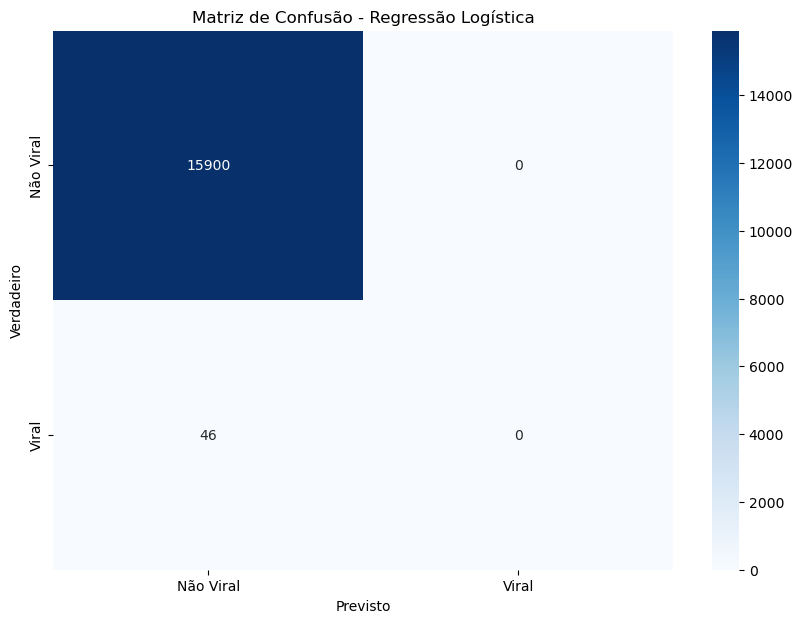


=== Árvore de Decisão ===
Acurácia: 0.9948
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           0.99     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      0.99      0.99     15946



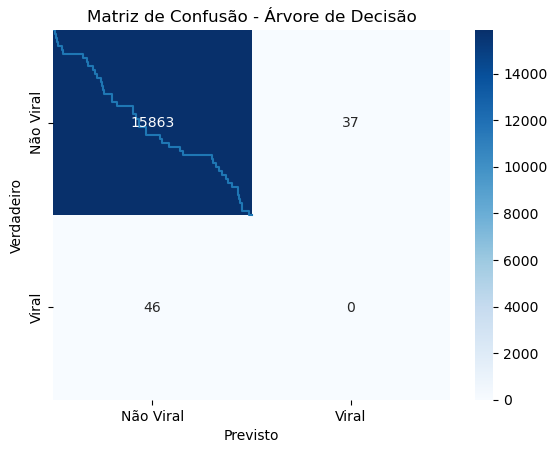


=== Random Forest ===
Acurácia: 0.9969
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           1.00     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      1.00      1.00     15946



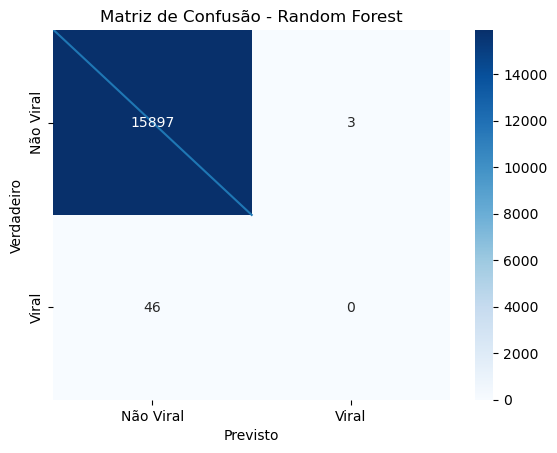

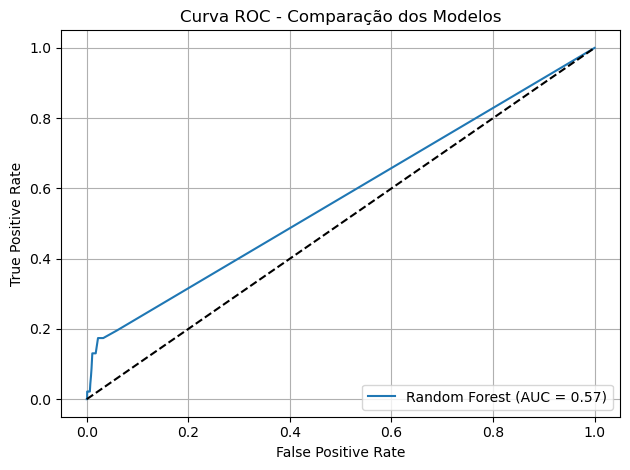

In [9]:
avaliar_modelos_binarios(X_train, X_test, y_train, y_test)

In [10]:
y.value_counts()

target
0    79498
1      230
Name: count, dtype: int64

### f)  Regularização:  Com  regularização  (Ridge,  Lasso  ou  ElasticNet)

In [11]:
def avaliar_regularizacao_logistica(X_train, X_test, y_train, y_test):
    modelos = {
        "Ridge (L2)": LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000),
        "Lasso (L1)": LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000),
        "ElasticNet (L1 + L2)": LogisticRegression(penalty='elasticnet', C=1.0, solver='saga', l1_ratio=0.5, max_iter=1000)
    }

    plt.figure(figsize=(10, 7))
    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1]

        # Métricas
        print(f"\n=== {nome} ===")
        print("Acurácia:", round(accuracy_score(y_test, y_pred), 4))
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=["Não Viral", "Viral"]))

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                    xticklabels=["Não Viral", "Viral"],
                    yticklabels=["Não Viral", "Viral"])
        plt.title(f"Matriz de Confusão - {nome}")
        plt.xlabel("Previsto")
        plt.ylabel("Verdadeiro")
        plt.show()

        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nome} (AUC = {roc_auc:.2f})')

    # Finalizar curva ROC
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - Regularizações Logísticas')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


=== Ridge (L2) ===
Acurácia: 0.9971
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           1.00     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      1.00      1.00     15946



/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

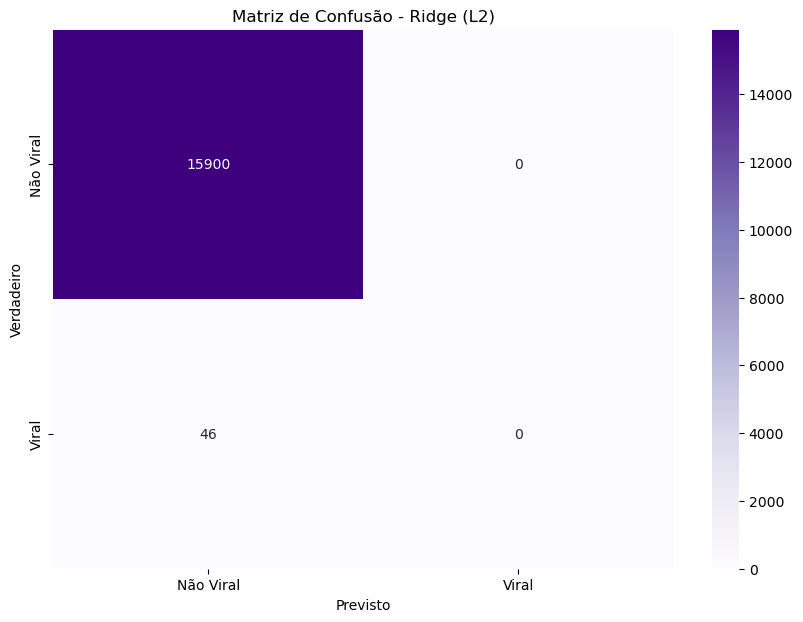


=== Lasso (L1) ===
Acurácia: 0.9971
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           1.00     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      1.00      1.00     15946



/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

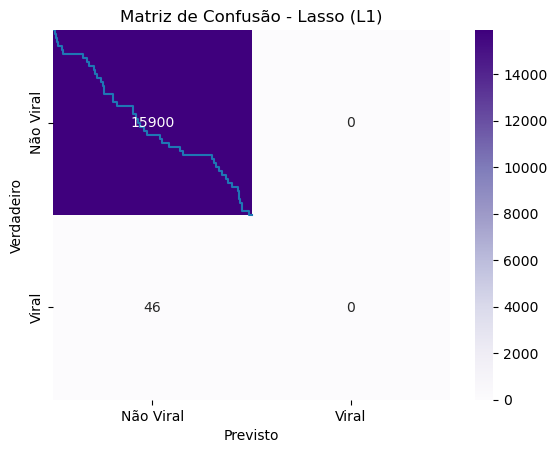


=== ElasticNet (L1 + L2) ===
Acurácia: 0.9971
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           1.00     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      1.00      1.00     15946



/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_clas

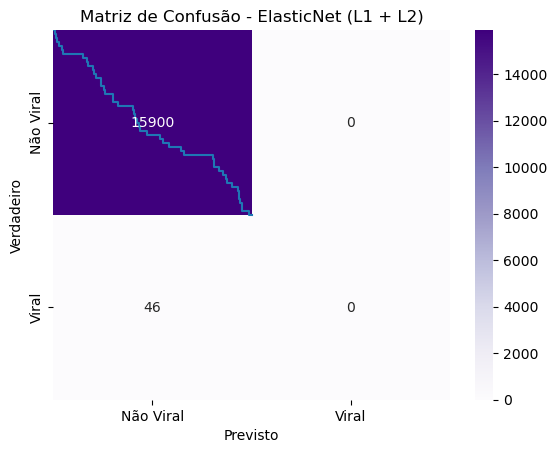

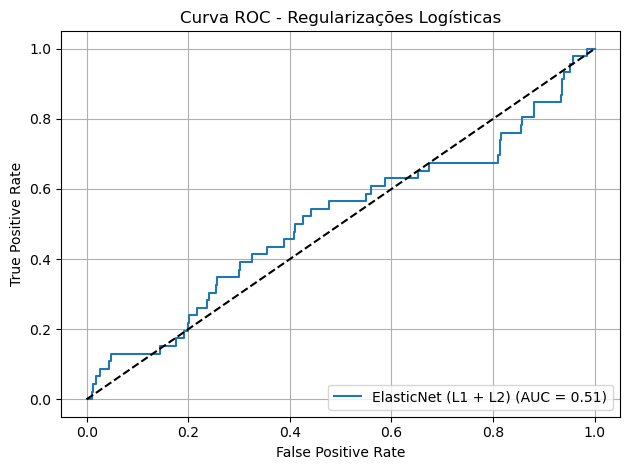

In [12]:
avaliar_regularizacao_logistica(X_train, X_test, y_train, y_test)


### g)  Normalização dos dados: sem normalização, Z-Score

In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== Regressão Logística ===
Acurácia: 0.9971
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           1.00     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      1.00      1.00     15946



/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

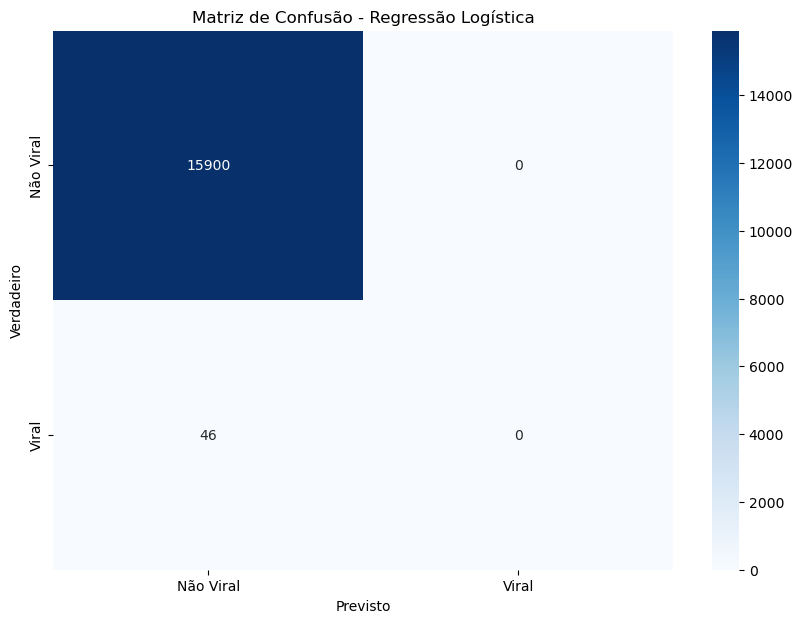


=== Árvore de Decisão ===
Acurácia: 0.9949
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           0.99     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      0.99      0.99     15946



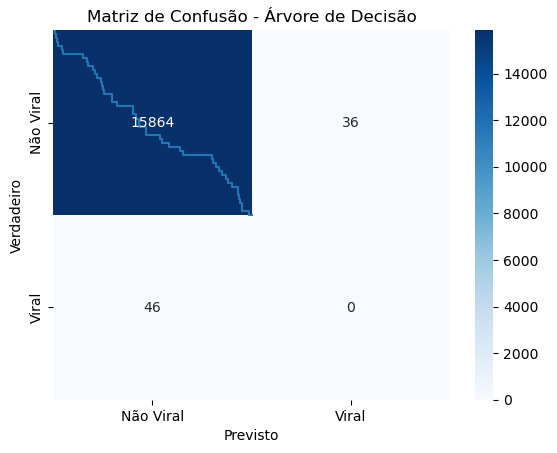


=== Random Forest ===
Acurácia: 0.9969
Classification Report:
              precision    recall  f1-score   support

   Não Viral       1.00      1.00      1.00     15900
       Viral       0.00      0.00      0.00        46

    accuracy                           1.00     15946
   macro avg       0.50      0.50      0.50     15946
weighted avg       0.99      1.00      1.00     15946



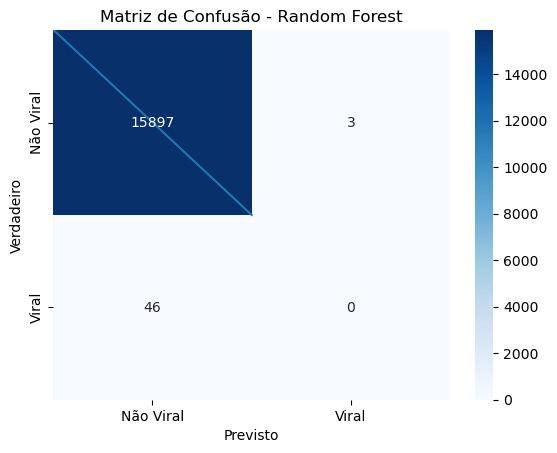

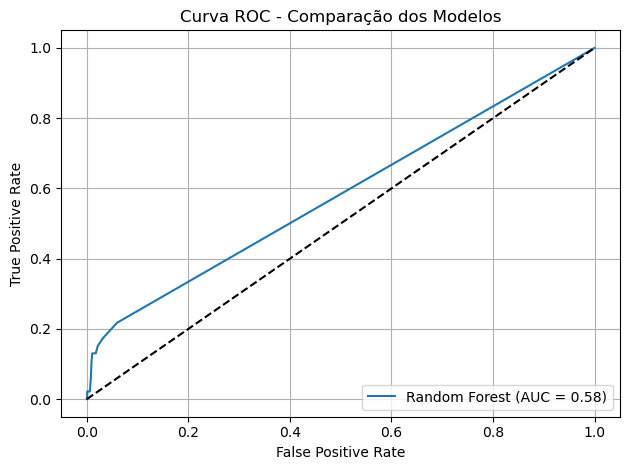

In [14]:
avaliar_modelos_binarios(X_train_scaled, X_test_scaled, y_train, y_test)

### h)  Pré-processamento de dados

#### Oversampling

In [15]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Após SMOTE:", y_resampled.value_counts())

Após SMOTE: target
0    79498
1    79498
Name: count, dtype: int64


In [16]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


=== Regressão Logística ===
Acurácia: 0.6524
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.61      0.82      0.70     15900
       Viral       0.73      0.49      0.58     15900

    accuracy                           0.65     31800
   macro avg       0.67      0.65      0.64     31800
weighted avg       0.67      0.65      0.64     31800



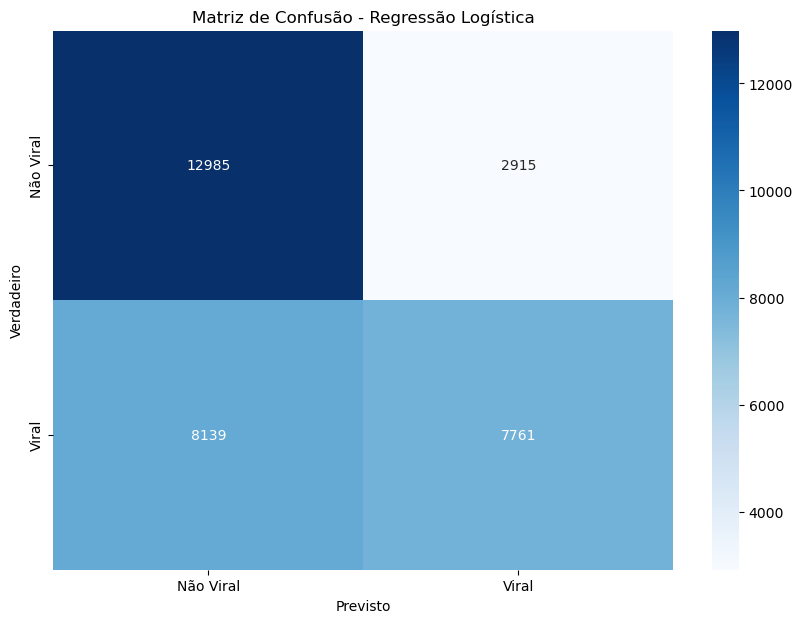


=== Árvore de Decisão ===
Acurácia: 0.9645
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.97      0.96      0.96     15900
       Viral       0.96      0.97      0.96     15900

    accuracy                           0.96     31800
   macro avg       0.96      0.96      0.96     31800
weighted avg       0.96      0.96      0.96     31800



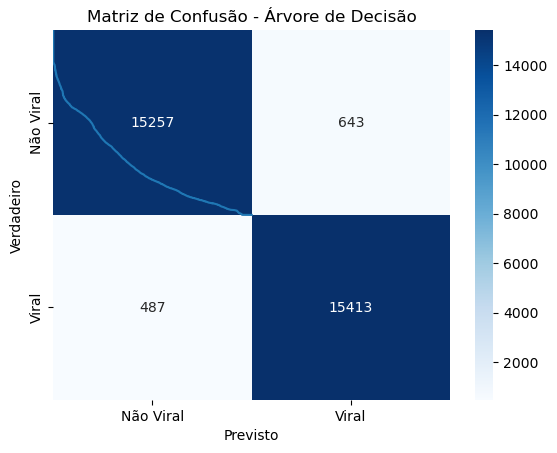


=== Random Forest ===
Acurácia: 0.9704
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.98      0.96      0.97     15900
       Viral       0.96      0.98      0.97     15900

    accuracy                           0.97     31800
   macro avg       0.97      0.97      0.97     31800
weighted avg       0.97      0.97      0.97     31800



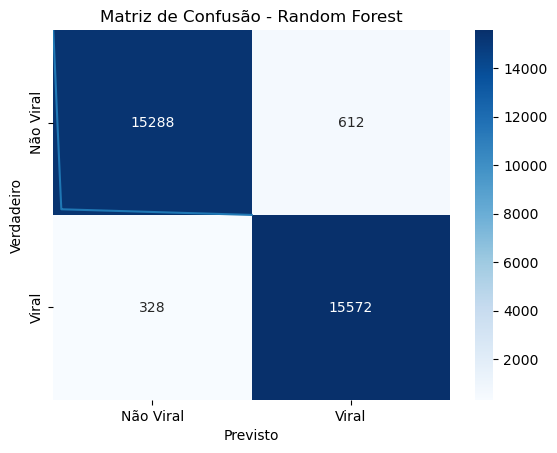

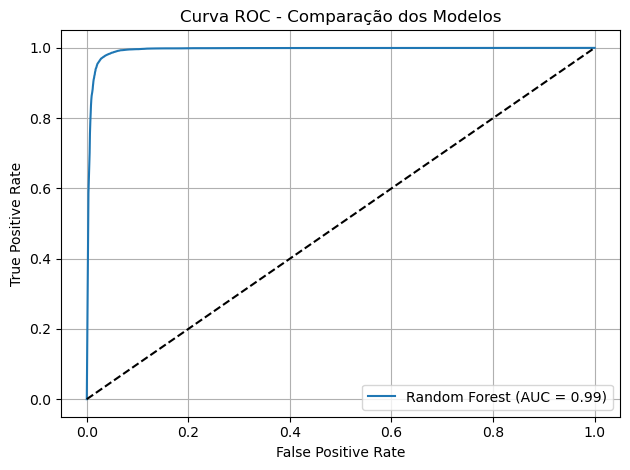

In [17]:
avaliar_modelos_binarios(X_train_smote, X_test_smote, y_train_smote, y_test_smote)

#### Undersampling

In [18]:
df_bal = pd.concat([pd.DataFrame(X), pd.Series(y, name='target')], axis=1)

df_major = df_bal[df_bal['target'] == 0]
df_minor = df_bal[df_bal['target'] == 1]

df_major_downsampled = resample(df_major, replace=False,
                                n_samples=len(df_minor),
                                random_state=42)

df_downsampled = pd.concat([df_major_downsampled, df_minor])

X_downsampled = df_downsampled.drop(columns=['target']).values
y_downsampled = df_downsampled['target'].values

print("Após undersampling:")
print(pd.Series(y_downsampled).value_counts())

Após undersampling:
0    230
1    230
Name: count, dtype: int64


In [19]:
X_train_dwnsample, X_test_dwnsample, y_train_dwnsample, y_test_dwnsample = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42, stratify=y_downsampled)


=== Regressão Logística ===
Acurácia: 0.4783
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.48      0.48      0.48        46
       Viral       0.48      0.48      0.48        46

    accuracy                           0.48        92
   macro avg       0.48      0.48      0.48        92
weighted avg       0.48      0.48      0.48        92



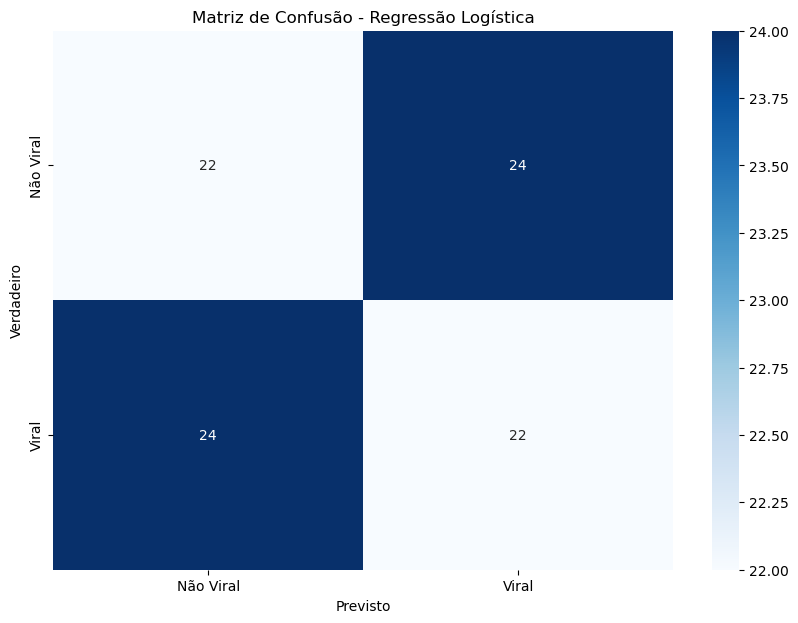


=== Árvore de Decisão ===
Acurácia: 0.6087
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.61      0.59      0.60        46
       Viral       0.60      0.63      0.62        46

    accuracy                           0.61        92
   macro avg       0.61      0.61      0.61        92
weighted avg       0.61      0.61      0.61        92



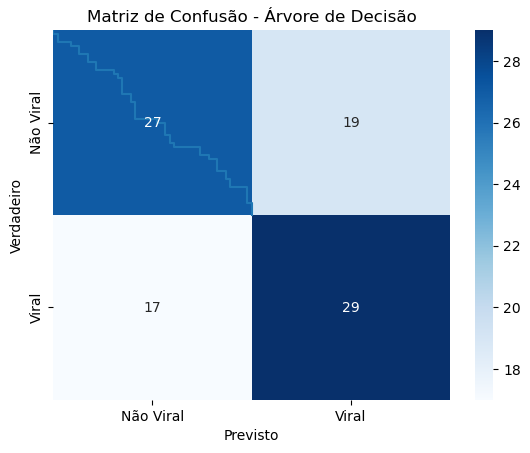


=== Random Forest ===
Acurácia: 0.7283
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.71      0.76      0.74        46
       Viral       0.74      0.70      0.72        46

    accuracy                           0.73        92
   macro avg       0.73      0.73      0.73        92
weighted avg       0.73      0.73      0.73        92



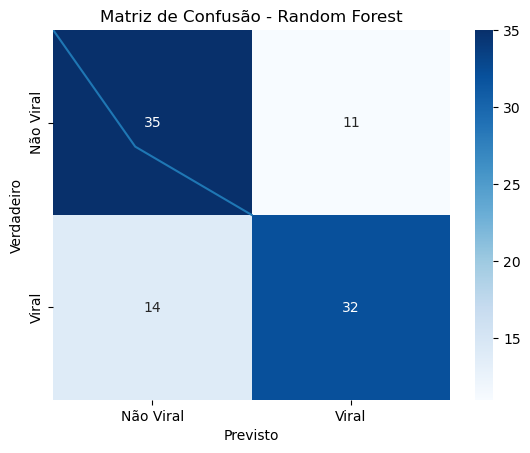

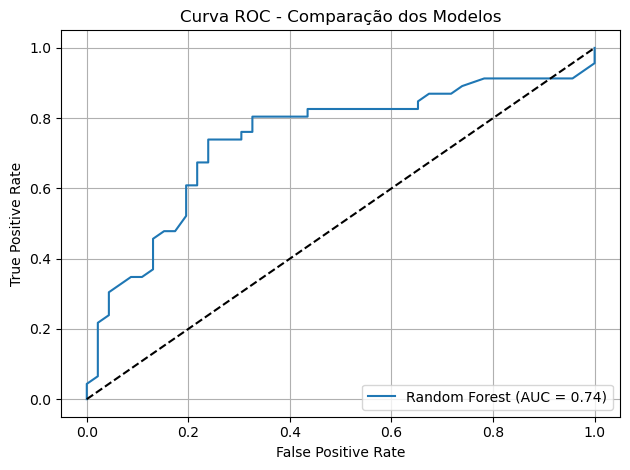

In [20]:
avaliar_modelos_binarios(X_train_dwnsample, X_test_dwnsample, y_train_dwnsample, y_test_dwnsample)

### i)  Embedding: BOW, TF-IDF, Word2Vec; 

In [21]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [23]:
stop_words = set(stopwords.words('portuguese')) | set(stopwords.words('english'))

In [40]:
label_1 = df[df['viral_label']=='viral']
label_0 = df[df['viral_label']=='não viral'].sample(len(label_1.index))

df_i = pd.concat([label_1, label_0])

In [43]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

df_i['texto_proc'] = df_i['texto_limpo'].fillna("").apply(preprocess_text)

In [46]:
df_i['viral_label'] = df_i['viral_label'].replace('viral', 1).replace('não viral', 0)

X_train_text, X_test_text, y_train, y_test = train_test_split(df_i['texto_proc'], df_i['viral_label'], test_size=0.2, random_state=42, stratify=df_i['viral_label'])

/tmp/ipykernel_17440/1508117711.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_i['viral_label'] = df_i['viral_label'].replace('viral', 1).replace('não viral', 0)


In [49]:
# === Bag of Words ===
bow_vectorizer = CountVectorizer(max_features=5000) 
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.transform(X_test_text)

# === TF-IDF ===
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

In [50]:
tokens_list = df_i['texto_proc'].apply(lambda x: x.split()).tolist()
w2v_model = Word2Vec(sentences=tokens_list, vector_size=100, window=5, min_count=5, workers=4)

# Função para vetor médio
def vectorize_w2v(tokens, model, size=100):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(size)

X_w2v = df_i['texto_proc'].apply(lambda t: vectorize_w2v(t.split(), w2v_model)).tolist()
X_w2v = np.array(X_w2v)

# Split
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, df_i['viral_label'], test_size=0.2, random_state=42, stratify=df_i['viral_label'])


=== Regressão Logística ===
Acurácia: 0.744
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.68      0.94      0.79        84
       Viral       0.90      0.55      0.68        84

    accuracy                           0.74       168
   macro avg       0.79      0.74      0.73       168
weighted avg       0.79      0.74      0.73       168



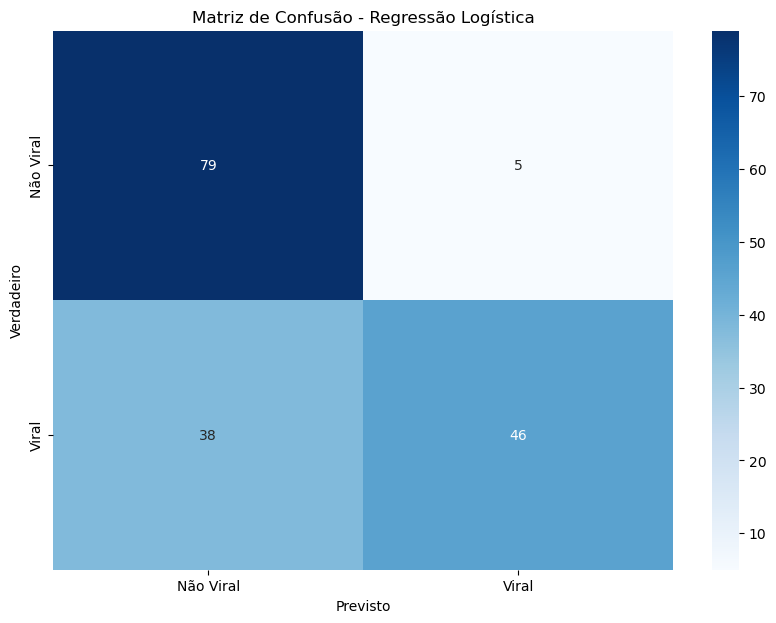


=== Árvore de Decisão ===
Acurácia: 0.7321
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.71      0.80      0.75        84
       Viral       0.77      0.67      0.71        84

    accuracy                           0.73       168
   macro avg       0.74      0.73      0.73       168
weighted avg       0.74      0.73      0.73       168



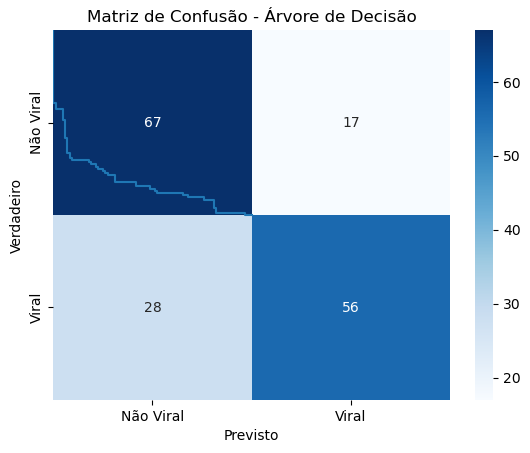


=== Random Forest ===
Acurácia: 0.75
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.69      0.92      0.79        84
       Viral       0.88      0.58      0.70        84

    accuracy                           0.75       168
   macro avg       0.78      0.75      0.74       168
weighted avg       0.78      0.75      0.74       168



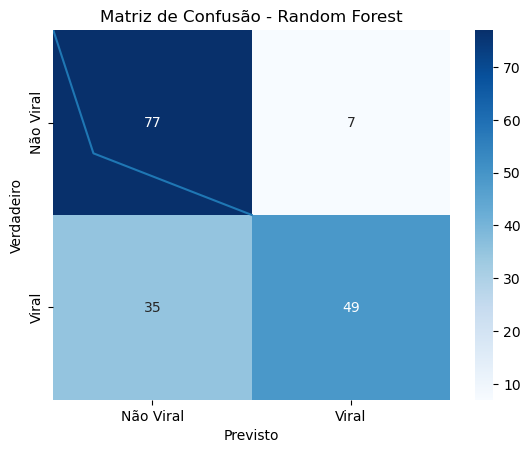

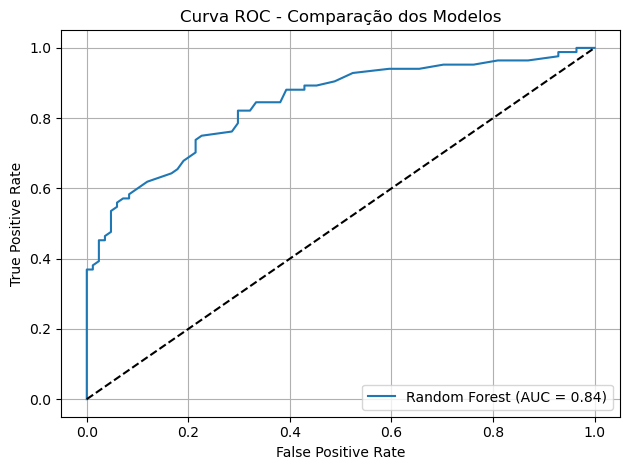

In [51]:
# Usando TF-IDF
avaliar_modelos_binarios(X_train_tfidf, X_test_tfidf, y_train, y_test)


=== Regressão Logística ===
Acurácia: 0.7857
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.74      0.88      0.80        84
       Viral       0.85      0.69      0.76        84

    accuracy                           0.79       168
   macro avg       0.80      0.79      0.78       168
weighted avg       0.80      0.79      0.78       168



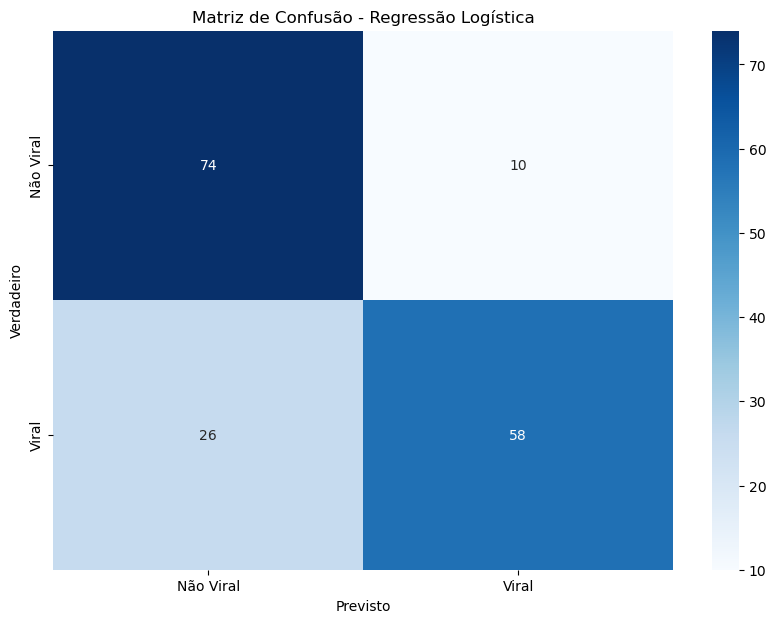


=== Árvore de Decisão ===
Acurácia: 0.7024
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.68      0.76      0.72        84
       Viral       0.73      0.64      0.68        84

    accuracy                           0.70       168
   macro avg       0.71      0.70      0.70       168
weighted avg       0.71      0.70      0.70       168



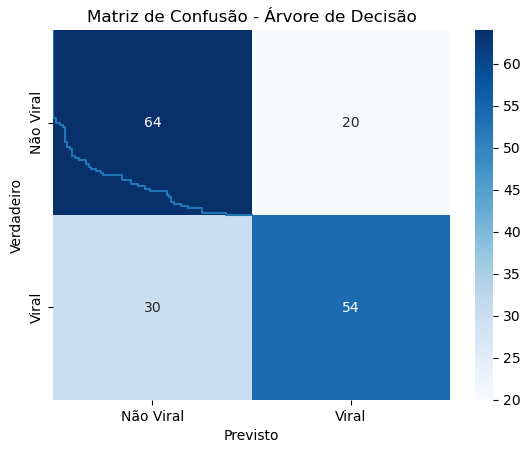


=== Random Forest ===
Acurácia: 0.7262
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.68      0.85      0.76        84
       Viral       0.80      0.61      0.69        84

    accuracy                           0.73       168
   macro avg       0.74      0.73      0.72       168
weighted avg       0.74      0.73      0.72       168



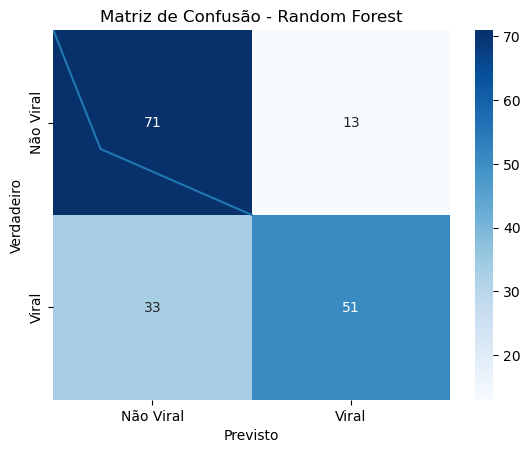

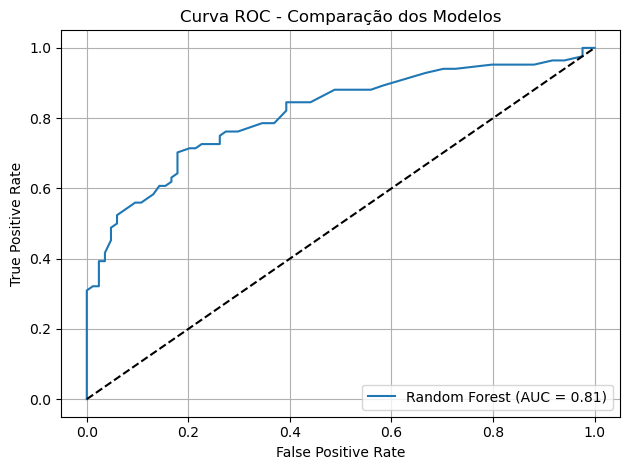

In [52]:
# Usando BoW
avaliar_modelos_binarios(X_train_bow, X_test_bow, y_train, y_test)


=== Regressão Logística ===
Acurácia: 0.5774
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.58      0.56      0.57        84
       Viral       0.57      0.60      0.58        84

    accuracy                           0.58       168
   macro avg       0.58      0.58      0.58       168
weighted avg       0.58      0.58      0.58       168



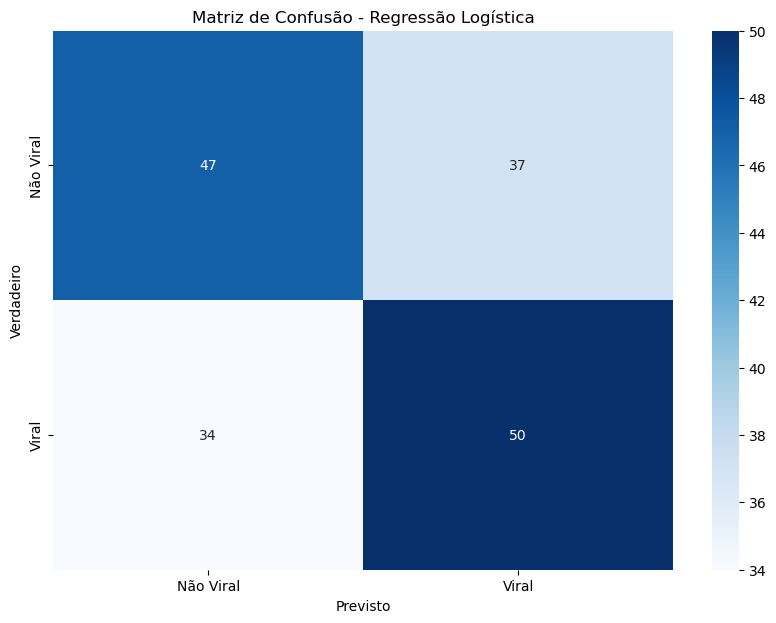


=== Árvore de Decisão ===
Acurácia: 0.5774
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.57      0.60      0.58        84
       Viral       0.58      0.56      0.57        84

    accuracy                           0.58       168
   macro avg       0.58      0.58      0.58       168
weighted avg       0.58      0.58      0.58       168



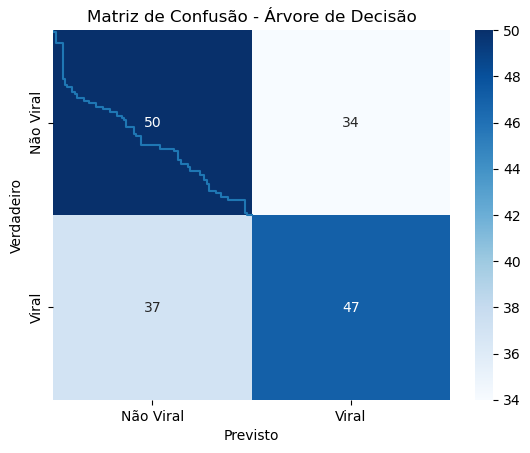


=== Random Forest ===
Acurácia: 0.6607
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.62      0.82      0.71        84
       Viral       0.74      0.50      0.60        84

    accuracy                           0.66       168
   macro avg       0.68      0.66      0.65       168
weighted avg       0.68      0.66      0.65       168



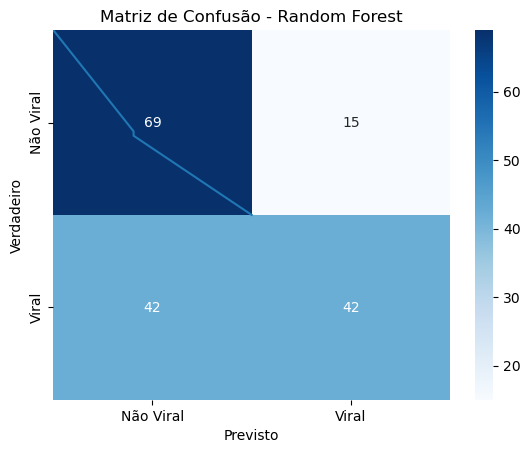

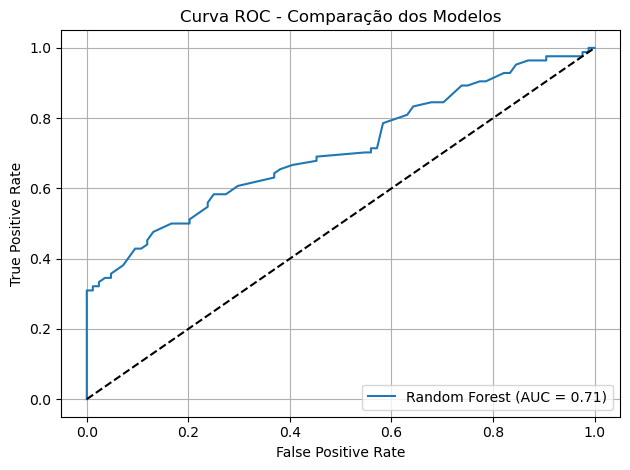

In [53]:
# Usando Word2Vec
avaliar_modelos_binarios(X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v)

### j)  N-Gramas: unigramas, bigramas, trigramas;

In [54]:
def gerar_tfidf_ngramas(corpus_treino, corpus_teste, ngrama=(1, 1), max_features=5000):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrama, max_features=max_features)
    X_train = tfidf_vectorizer.fit_transform(corpus_treino)
    X_test = tfidf_vectorizer.transform(corpus_teste)
    return X_train, X_test, tfidf_vectorizer


In [57]:
X_train_txt, X_test_txt, y_train, y_test = train_test_split(df_i['texto_proc'], df_i['viral_label'], test_size=0.2, random_state=42, stratify=df_i['viral_label'])



=== Regressão Logística ===
Acurácia: 0.744
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.68      0.94      0.79        84
       Viral       0.90      0.55      0.68        84

    accuracy                           0.74       168
   macro avg       0.79      0.74      0.73       168
weighted avg       0.79      0.74      0.73       168



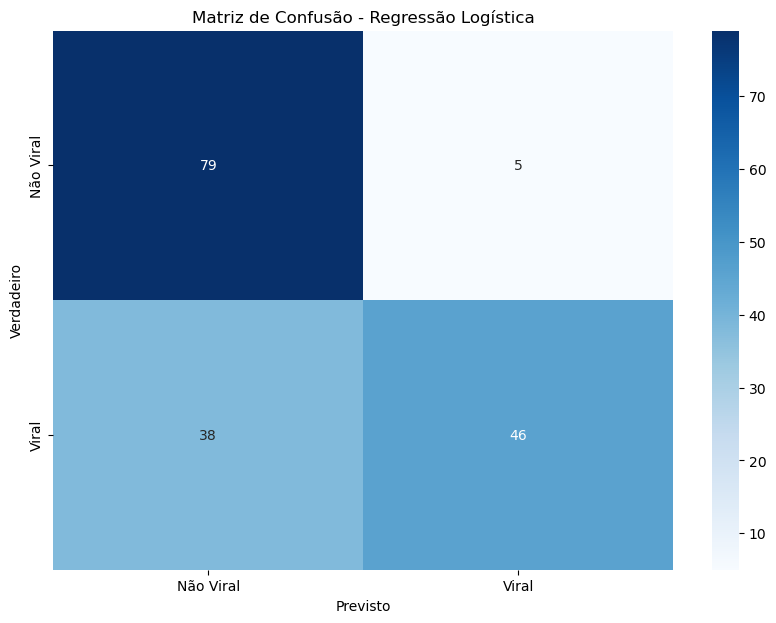


=== Árvore de Decisão ===
Acurácia: 0.7321
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.71      0.80      0.75        84
       Viral       0.77      0.67      0.71        84

    accuracy                           0.73       168
   macro avg       0.74      0.73      0.73       168
weighted avg       0.74      0.73      0.73       168



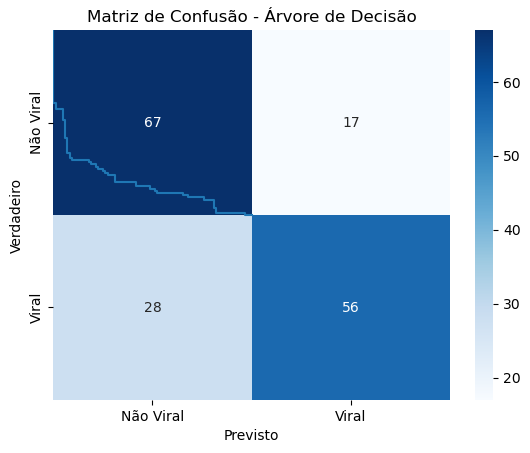


=== Random Forest ===
Acurácia: 0.75
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.69      0.92      0.79        84
       Viral       0.88      0.58      0.70        84

    accuracy                           0.75       168
   macro avg       0.78      0.75      0.74       168
weighted avg       0.78      0.75      0.74       168



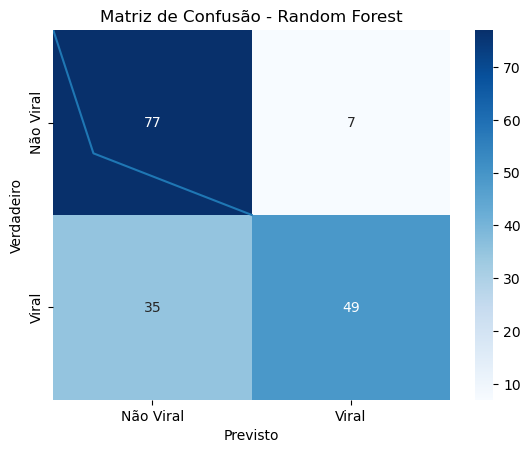

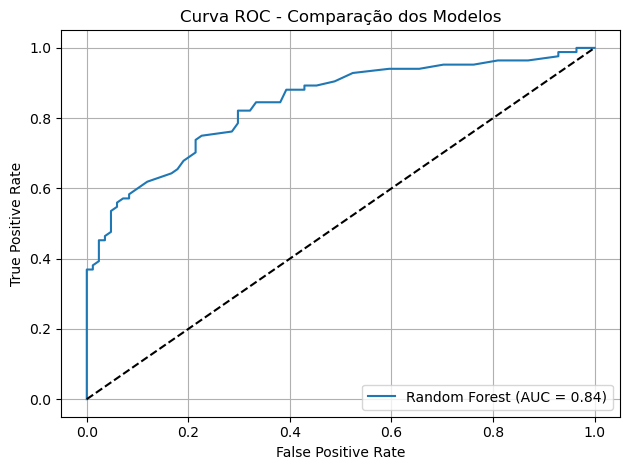

In [58]:
X_train_uni, X_test_uni, _ = gerar_tfidf_ngramas(X_train_txt, X_test_txt, ngrama=(1,1))
avaliar_modelos_binarios(X_train_uni, X_test_uni, y_train, y_test)


=== Regressão Logística ===
Acurácia: 0.756
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.69      0.94      0.79        84
       Viral       0.91      0.57      0.70        84

    accuracy                           0.76       168
   macro avg       0.80      0.76      0.75       168
weighted avg       0.80      0.76      0.75       168



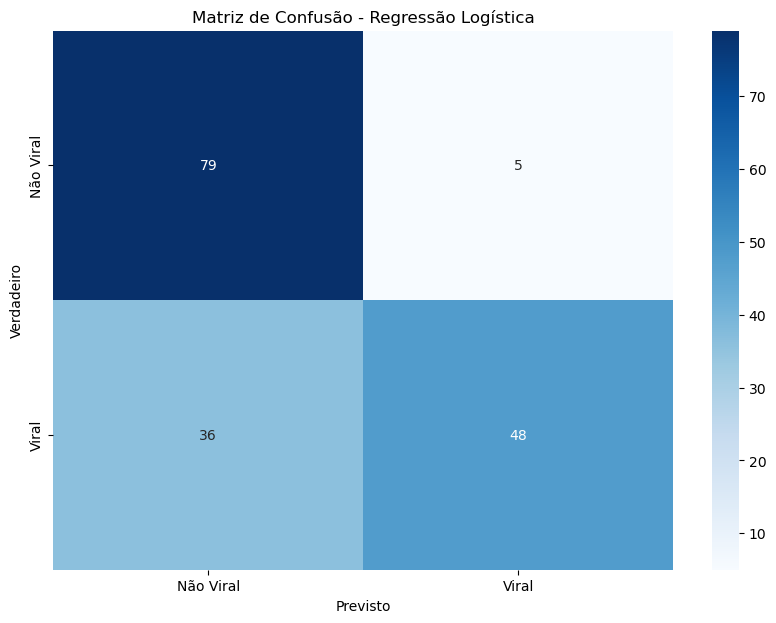


=== Árvore de Decisão ===
Acurácia: 0.7202
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.72      0.71      0.72        84
       Viral       0.72      0.73      0.72        84

    accuracy                           0.72       168
   macro avg       0.72      0.72      0.72       168
weighted avg       0.72      0.72      0.72       168



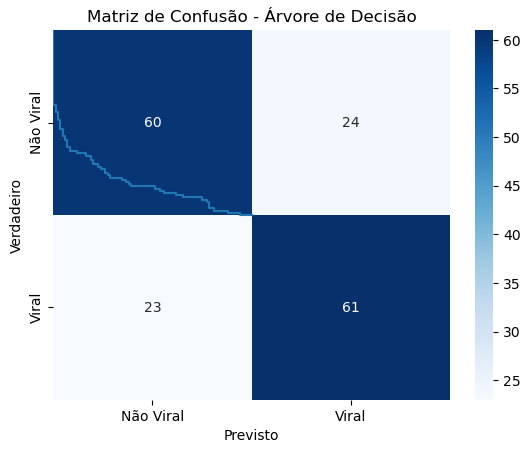


=== Random Forest ===
Acurácia: 0.7381
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.69      0.86      0.77        84
       Viral       0.81      0.62      0.70        84

    accuracy                           0.74       168
   macro avg       0.75      0.74      0.73       168
weighted avg       0.75      0.74      0.73       168



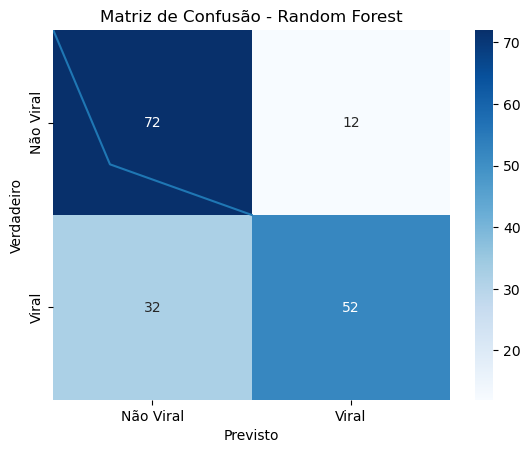

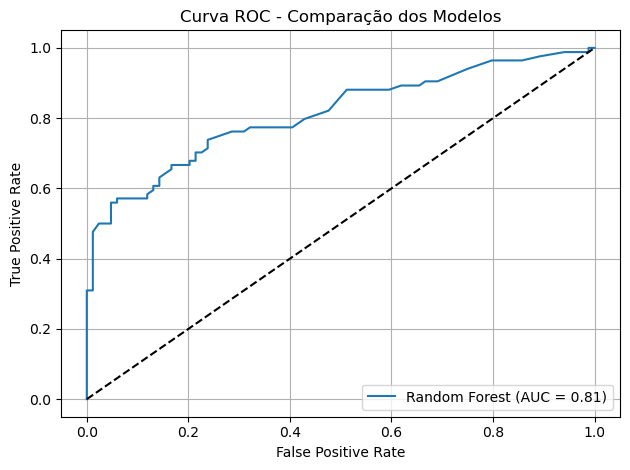

In [59]:
X_train_bi, X_test_bi, _ = gerar_tfidf_ngramas(X_train_txt, X_test_txt, ngrama=(1,2))
avaliar_modelos_binarios(X_train_bi, X_test_bi, y_train, y_test)



=== Regressão Logística ===
Acurácia: 0.756
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.69      0.94      0.79        84
       Viral       0.91      0.57      0.70        84

    accuracy                           0.76       168
   macro avg       0.80      0.76      0.75       168
weighted avg       0.80      0.76      0.75       168



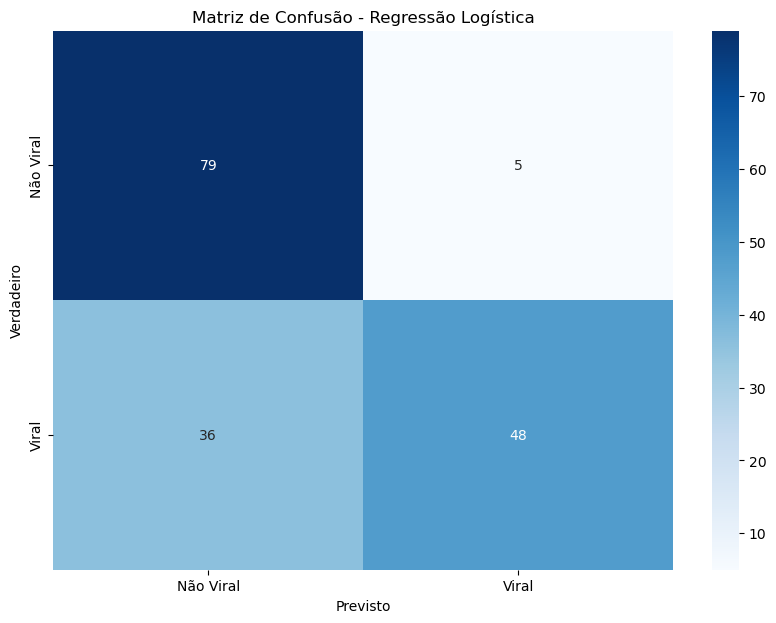


=== Árvore de Decisão ===
Acurácia: 0.7083
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.71      0.70      0.71        84
       Viral       0.71      0.71      0.71        84

    accuracy                           0.71       168
   macro avg       0.71      0.71      0.71       168
weighted avg       0.71      0.71      0.71       168



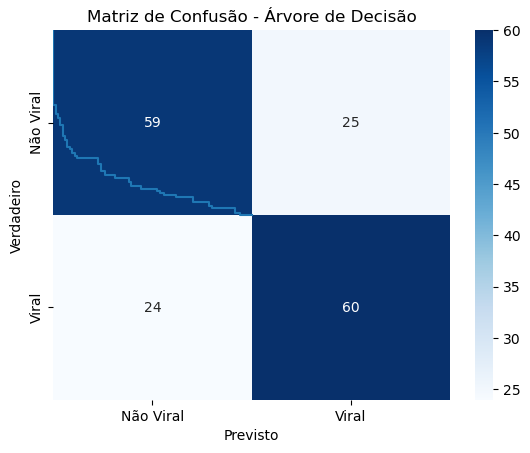


=== Random Forest ===
Acurácia: 0.7321
Classification Report:
              precision    recall  f1-score   support

   Não Viral       0.69      0.85      0.76        84
       Viral       0.80      0.62      0.70        84

    accuracy                           0.73       168
   macro avg       0.74      0.73      0.73       168
weighted avg       0.74      0.73      0.73       168



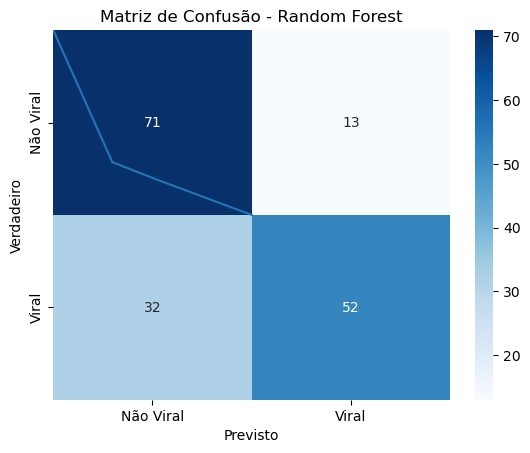

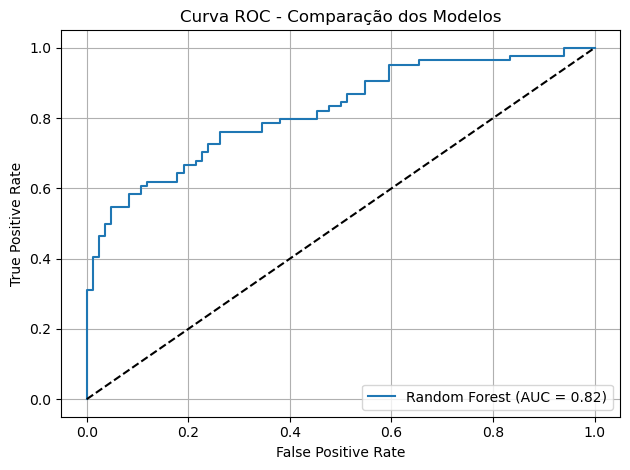

In [60]:
X_train_tri, X_test_tri, _ = gerar_tfidf_ngramas(X_train_txt, X_test_txt, ngrama=(1,3))
avaliar_modelos_binarios(X_train_tri, X_test_tri, y_train, y_test)


### k)  Treinamento, Validação e Teste: Outer K-Fold Cross-Validation

In [63]:
def outer_kfold_cross_validation(texts, labels, ngram_range=(1,1), k=5, max_features=5000):
    tfidf = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_all = tfidf.fit_transform(texts)
    y_all = np.array(labels)

    outer_kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Modelos a testar
    modelos = {
        "LogReg": LogisticRegression(max_iter=1000, random_state=42),
        "Tree": DecisionTreeClassifier(random_state=42),
        "RF": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    # Resultados por modelo
    resultados = {nome: [] for nome in modelos}

    for fold, (train_idx, test_idx) in enumerate(outer_kf.split(X_all)):
        print(f"\nFold {fold+1}/{k}")
        X_train, X_test = X_all[train_idx], X_all[test_idx]
        y_train, y_test = y_all[train_idx], y_all[test_idx]

        for nome, modelo in modelos.items():
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            y_proba = modelo.predict_proba(X_test)[:, 1]

            acc = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_proba)

            resultados[nome].append((acc, auc))

            print(f"{nome}: acc = {acc:.4f}, AUC = {auc:.4f}")

    # Resultados médios
    print("\nResultados Médios:")
    for nome in modelos:
        accs, aucs = zip(*resultados[nome])
        print(f"{nome}: Média Acc = {np.mean(accs):.4f}, Média AUC = {np.mean(aucs):.4f}")


In [67]:
def outer_kfold_numerico(X, y, k=5):
    modelos = {
        "LogReg": LogisticRegression(max_iter=1000, random_state=42),
        "Tree": DecisionTreeClassifier(random_state=42),
        "RF": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    resultados = {nome: [] for nome in modelos}
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/{k}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Normalização (z-score) — só no treino
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for nome, modelo in modelos.items():
            modelo.fit(X_train_scaled, y_train)
            y_pred = modelo.predict(X_test_scaled)
            y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

            acc = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_proba)

            resultados[nome].append((acc, auc))

            print(f"{nome}: acc = {acc:.4f}, AUC = {auc:.4f}")

    # Médias finais
    print("\nResultados Médios:")
    for nome in modelos:
        accs, aucs = zip(*resultados[nome])
        print(f"{nome}: Média Acc = {np.mean(accs):.4f}, Média AUC = {np.mean(aucs):.4f}")


In [64]:
outer_kfold_cross_validation(df['texto_proc'], df['viral_label'], ngram_range=(1,2))


Fold 1/5
LogReg: acc = 0.9972, AUC = 0.8616
Tree: acc = 0.9964, AUC = 0.5882
RF: acc = 0.9972, AUC = 0.6655

Fold 2/5
LogReg: acc = 0.9980, AUC = 0.8162
Tree: acc = 0.9964, AUC = 0.6179
RF: acc = 0.9978, AUC = 0.6762

Fold 3/5
LogReg: acc = 0.9972, AUC = 0.8355
Tree: acc = 0.9964, AUC = 0.6019
RF: acc = 0.9971, AUC = 0.6842

Fold 4/5
LogReg: acc = 0.9971, AUC = 0.8637
Tree: acc = 0.9956, AUC = 0.6279
RF: acc = 0.9970, AUC = 0.6878

Fold 5/5
LogReg: acc = 0.9974, AUC = 0.7731
Tree: acc = 0.9960, AUC = 0.5915
RF: acc = 0.9972, AUC = 0.6770

Resultados Médios:
LogReg: Média Acc = 0.9974, Média AUC = 0.8300
Tree: Média Acc = 0.9962, Média AUC = 0.6055
RF: Média Acc = 0.9973, Média AUC = 0.6782


In [69]:
X_smote = pd.concat([X_train_smote, X_test_smote]).reset_index(drop=True)
y_smote = pd.concat([y_train_smote, y_test_smote]).reset_index(drop=True)

In [75]:
outer_kfold_numerico(X_smote.values, y_smote.values, 5)


Fold 1/5
LogReg: acc = 0.6510, AUC = 0.7415
Tree: acc = 0.9647, AUC = 0.9647
RF: acc = 0.9713, AUC = 0.9942

Fold 2/5
LogReg: acc = 0.6446, AUC = 0.7359
Tree: acc = 0.9632, AUC = 0.9631
RF: acc = 0.9705, AUC = 0.9936

Fold 3/5
LogReg: acc = 0.6494, AUC = 0.7385
Tree: acc = 0.9648, AUC = 0.9649
RF: acc = 0.9715, AUC = 0.9942

Fold 4/5
LogReg: acc = 0.6527, AUC = 0.7421
Tree: acc = 0.9656, AUC = 0.9656
RF: acc = 0.9718, AUC = 0.9938

Fold 5/5
LogReg: acc = 0.6552, AUC = 0.7431
Tree: acc = 0.9622, AUC = 0.9623
RF: acc = 0.9708, AUC = 0.9934

Resultados Médios:
LogReg: Média Acc = 0.6506, Média AUC = 0.7402
Tree: Média Acc = 0.9641, Média AUC = 0.9641
RF: Média Acc = 0.9712, Média AUC = 0.9938
